In [1]:
import numpy as np
import matplotlib.image as mpimg
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from imgaug import augmenters as iaa

In [2]:
dude = '/home/cyrano5614/Documents/webcam/dude.jpg'
hand = '/home/cyrano5614/Documents/webcam/hands.jpg'

In [5]:
def preprocess(image):

    img = mpimg.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (64, 64))

    return img

def augmentation(image, size=1000):

    img = image[..., np.newaxis]
    seq = iaa.Sequential([iaa.Crop(px=(0, 16)), iaa.Fliplr(0.5),
                          iaa.GaussianBlur(sigma=(0, 3.0))])

    images_aug = np.empty([size, 64, 64, 1])

    for i in range(size):
        image = img
        output = seq.augment_images([image])
        output = np.array(output)
        images_aug[i] = output

    return images_aug


def plot_images(images):

    plt.figure(figsize=(20,10))

    for i in range(12):
        img_draw = np.squeeze(images[i], axis=(2,))
        plt.subplot(3, 4, i+1)
        plt.imshow(img_draw)

    plt.show()


def visualize(img_path):
    plot_images(augmentation(preprocess(img_path)))

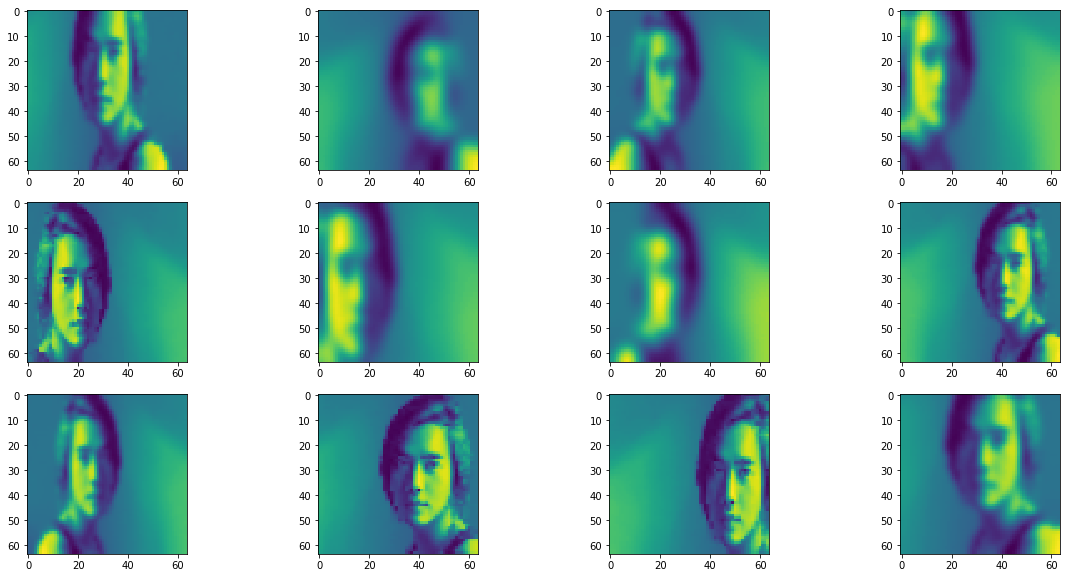

In [6]:
visualize(dude)

In [ ]:
def hog_features(img, visualize = False):
    
    if visualize == False:
        hog_array = hog(img)
        return hog_array
    else:
        hog_array, hog_img = hog(img)
        return hog_array, hog_img


def augment_hog(img):

    images = augmentation(img)
    hog_output = np.empty([1000, 2916])

    for i, image in enumerate(images):
        img_hog = np.squeeze(image, axis=(2,))
        img_hog = hog_features(img_hog)
        hog_output[i] = img_hog


In [8]:
cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

while rval:
    # print(frame.shape)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(frame_gray, 50, 150)
    # print(frame_gray.shape)
    # frame_final = np.vstack((frame, frame_gray))
    frame_final = edges
    cv2.imshow("preview", frame_final)
    rval, frame = vc.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
cv2.destroyWindow("preview")